In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [2]:
df = pd.read_csv("../../preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

BasketID          BasketDate  Sale  CustomerID CustomerCountry  \
0         536365 2010-01-12 08:26:00  2.55     17850.0  United Kingdom   
1         536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom   
2         536365 2010-01-12 08:26:00  2.75     17850.0  United Kingdom   
3         536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom   
4         536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom   
...          ...                 ...   ...         ...             ...   
541904    581587 2011-09-12 12:50:00  0.85     12680.0          France   
541905    581587 2011-09-12 12:50:00  2.10     12680.0          France   
541906    581587 2011-09-12 12:50:00  4.15     12680.0          France   
541907    581587 2011-09-12 12:50:00  4.15     12680.0          France   
541908    581587 2011-09-12 12:50:00  4.95     12680.0          France   

        ProdID                            ProdDescr  Qta  
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER    6  
1        71053                  WHITE METAL LANTERN    6  
2       84406B       CREAM CUPID HEARTS COAT HANGER    8  
3       84029G  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       84029E       RED WOOLLY HOTTIE WHITE HEART.    6  
...        ...                                  ...  ...  
541904   22613          PACK OF 20 SPACEBOY NAPKINS   12  
541905   22899         CHILDREN'S APRON DOLLY GIRL     6  
541906   23254        CHILDRENS CUTLERY DOLLY GIRL     4  
541907   23255      CHILDRENS CUTLERY CIRCUS PARADE    4  
541908   22138        BAKING SET 9 PIECE RETROSPOT     3  

[258672 rows x 8 columns]

## Estrazione degli indicatori

Si estraggono gli indicatori per ogni autore dai record del dataset

In [4]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

I         Iu     spending  Imax  avg_bought  baskets  \
CustomerID                                                                  
12347.0     164.571429  12.285714   416.905714   330    3.137986        7   
12348.0       6.000000   1.000000   240.000000     6   40.000000        1   
12349.0     465.000000  63.000000  1233.910000   465    3.714603        1   
12350.0     172.000000  15.000000   274.000000   172    1.630000        1   
12352.0      68.857143   7.857143   214.991429   103    5.148158        7   
...                ...        ...          ...   ...         ...      ...   
18280.0      45.000000  10.000000   180.600000    45    4.765000        1   
18281.0      52.000000   5.000000    46.920000    52    1.092000        1   
18282.0      26.500000   4.500000    69.315000    28    4.066667        2   
18283.0      65.066667   9.933333    89.911333   230    1.411297       15   
18287.0     146.000000  15.000000   255.390000   194    2.123000        2   

                   E  
CustomerID            
12347.0     6.217788  
12348.0     0.000000  
12349.0     5.786721  
12350.0     3.891479  
12352.0     5.454556  
...              ...  
18280.0     3.207542  
18281.0     2.281445  
18282.0     2.962478  
18283.0     6.757038  
18287.0     4.814997  

[4150 rows x 7 columns]

In [5]:
customer_indicators.describe()

I           Iu     spending         Imax   avg_bought  \
count  4150.000000  4150.000000  4150.000000  4150.000000  4150.000000   
mean    101.228624    13.745575   232.548074   146.372048     3.419600   
std      86.226957    12.247100   203.760553   127.699879     4.274995   
min       2.000000     0.200000     0.840000     2.000000     0.347500   
25%      47.000000     6.000000   108.991250    61.000000     2.190041   
50%      82.000000    10.732143   184.641771   115.000000     2.959688   
75%     131.661765    17.666667   299.090536   194.000000     3.878626   
max    1507.000000   202.000000  3343.190000  1507.000000   145.000000   

           baskets            E  
count  4150.000000  4150.000000  
mean      3.940000     4.363661  
std       6.699954     1.643364  
min       1.000000     0.000000  
25%       1.000000     3.321256  
50%       2.000000     4.454893  
75%       4.000000     5.546482  
max     191.000000     9.891737

In [6]:
customer_indicators.corr().abs().style.background_gradient(cmap='coolwarm')

## Scaling degl indicatori

Si applica all'intero dataset uno scaling della forma Min-Max

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

customer_indicators[customer_indicators.columns]=scaler.fit_transform(customer_indicators)
customer_indicators

I        Iu  spending      Imax  avg_bought   baskets  \
CustomerID                                                                 
12347.0     0.108021  0.059890  0.124483  0.217940    0.019291  0.031579   
12348.0     0.002658  0.003964  0.071554  0.002658    0.274122  0.000000   
12349.0     0.307641  0.311199  0.368923  0.307641    0.023277  0.000000   
12350.0     0.112957  0.073340  0.081727  0.112957    0.008866  0.000000   
12352.0     0.044423  0.037944  0.064072  0.067110    0.033188  0.031579   
...              ...       ...       ...       ...         ...       ...   
18280.0     0.028571  0.048563  0.053783  0.028571    0.030539  0.000000   
18281.0     0.033223  0.023786  0.013787  0.033223    0.005147  0.000000   
18282.0     0.016279  0.021308  0.020487  0.017276    0.025711  0.005263   
18283.0     0.041905  0.048233  0.026649  0.151495    0.007354  0.073684   
18287.0     0.095681  0.073340  0.076159  0.127575    0.012274  0.005263   

                   E  
CustomerID            
12347.0     0.628584  
12348.0     0.000000  
12349.0     0.585006  
12350.0     0.393407  
12352.0     0.551425  
...              ...  
18280.0     0.324265  
18281.0     0.230642  
18282.0     0.299490  
18283.0     0.683099  
18287.0     0.486770  

[4150 rows x 7 columns]

### Rimozione degli outliers

<AxesSubplot:xlabel='CustomerID'>

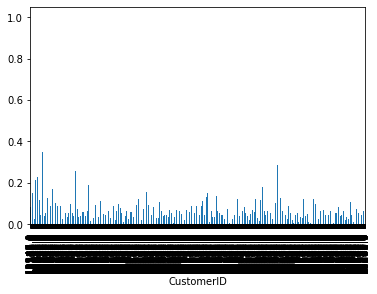

In [8]:
customer_indicators["spending"].plot.bar()

<AxesSubplot:>

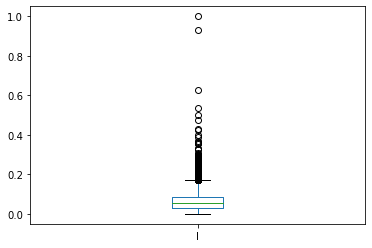

In [9]:
customer_indicators["I"].plot.box()

<AxesSubplot:>

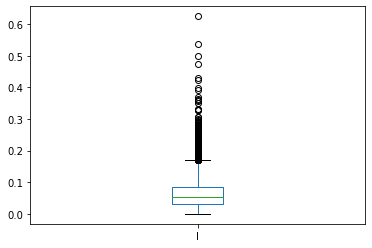

In [10]:
customer_indicators=customer_indicators[customer_indicators["I"]<0.8]
customer_indicators["I"].plot.box()

<AxesSubplot:>

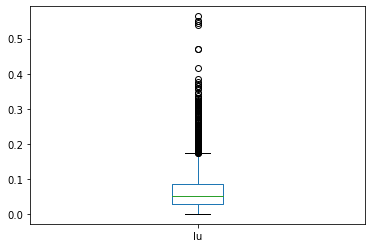

In [11]:
customer_indicators["Iu"].plot.box()

<AxesSubplot:>

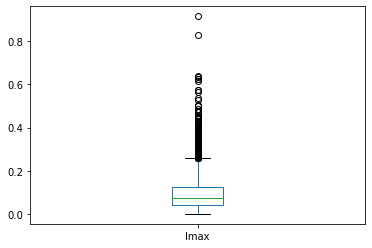

In [12]:
customer_indicators["Imax"].plot.box()

<AxesSubplot:>

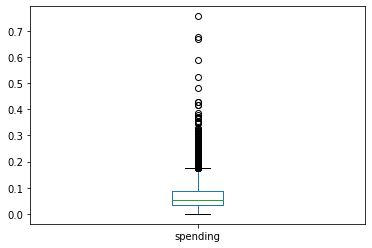

In [13]:
customer_indicators["spending"].plot.box()

<AxesSubplot:>

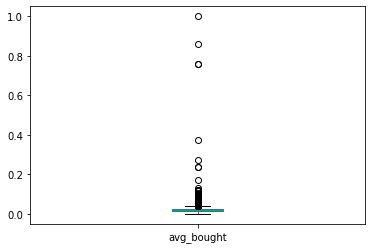

In [14]:
customer_indicators["avg_bought"].plot.box()

<AxesSubplot:>

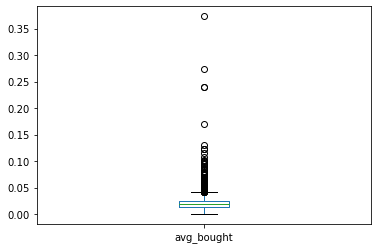

In [15]:
customer_indicators=customer_indicators[customer_indicators["avg_bought"]<0.6]
customer_indicators["avg_bought"].plot.box()

<AxesSubplot:>

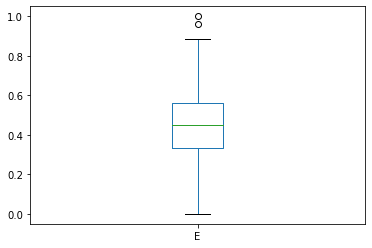

In [16]:
customer_indicators["E"].plot.box()

<AxesSubplot:>

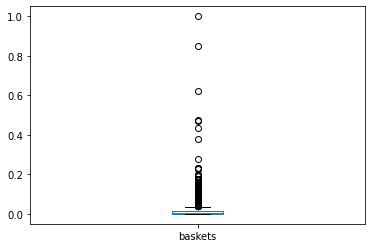

In [17]:
customer_indicators["baskets"].plot.box()

# K-Means

TODO

# Density based clustering

TODO

# Hierarchical clustering

Si sperimentano varie invocazioni dell'oggetto `AgglomerativeClustering` e come i clusters generati cambiano al variare delle metriche adottate.

In [18]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering(X, levels):
    for linkage in {"average", "complete", "single", "ward"}:
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
        model.fit_predict(X)
        plt.figure(figsize=(15, 10))
        plot_dendrogram(model, truncate_mode='level', p=levels)
        plt.title(linkage)

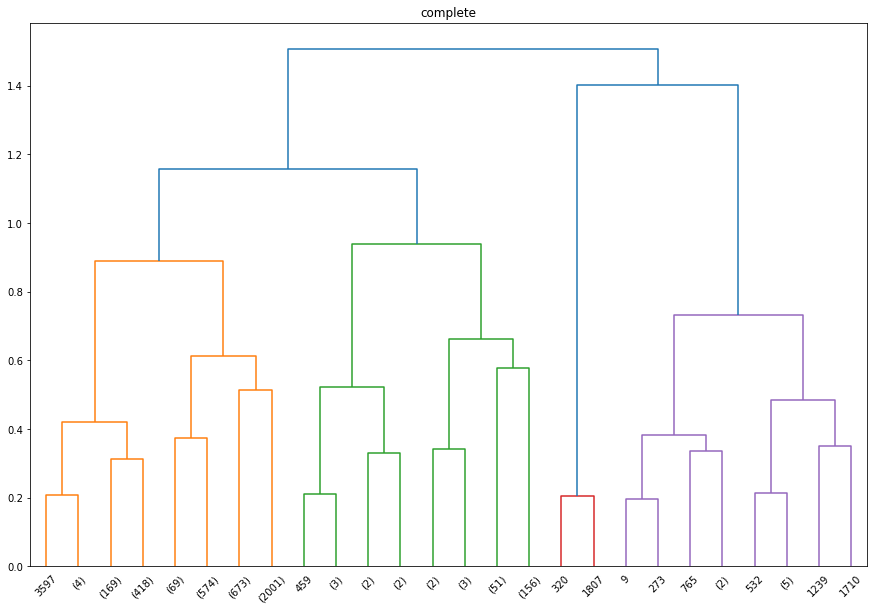

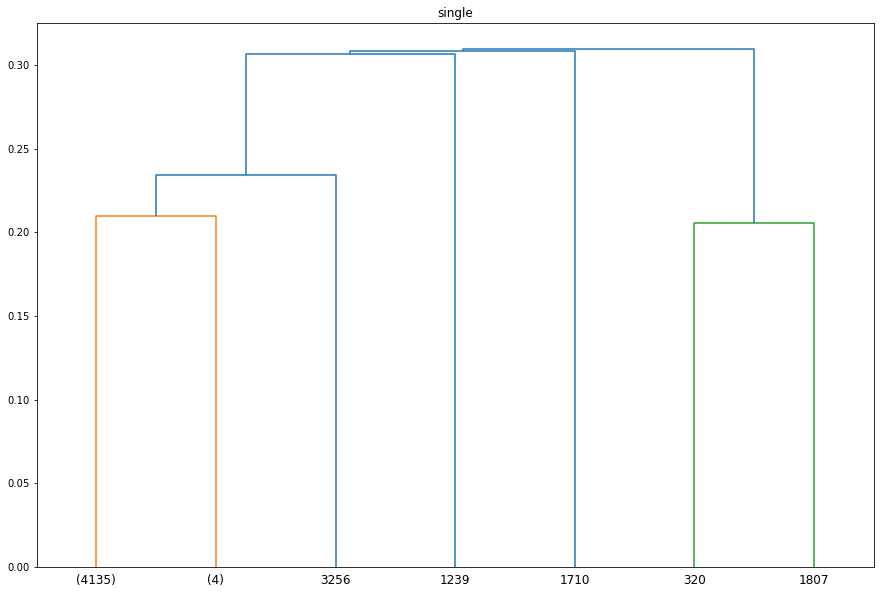

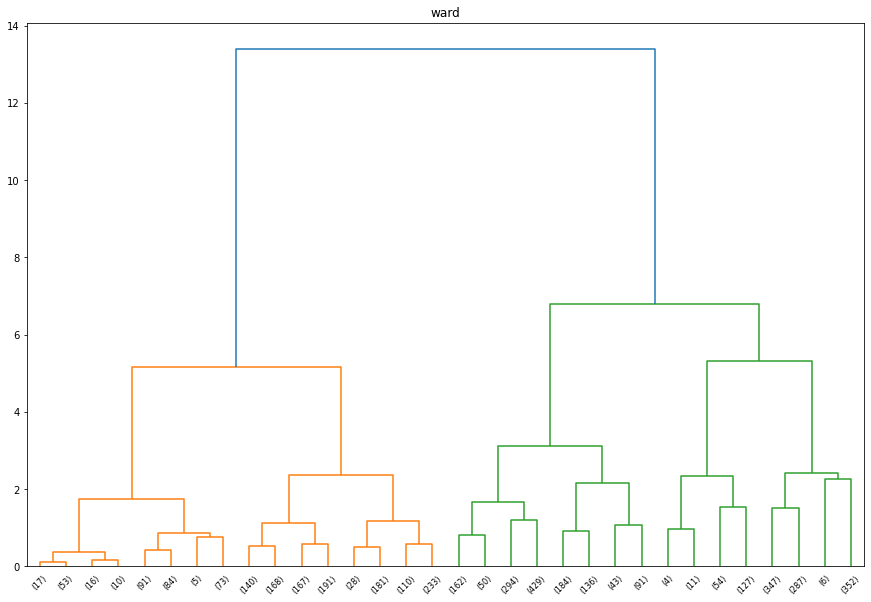

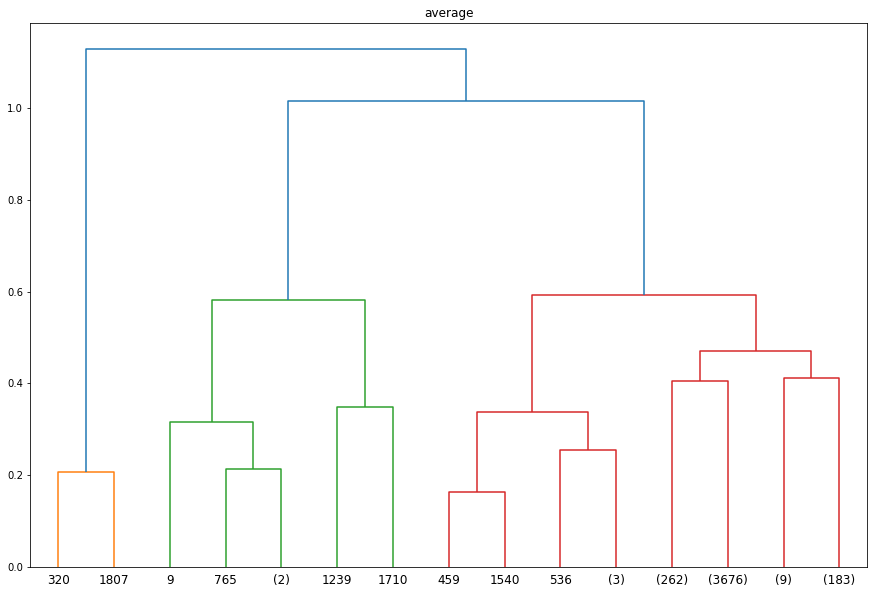

In [20]:
hierarchical_clustering(customer_indicators.values, 4)

In [21]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette


def xmeans_clustering(X, min_clusters, max_clusters):
    # Computes initial centers with kmeans++
    initial_centers = kmeans_plusplus_initializer(X, min_clusters).initialize()
    # Computes final clusters and centroids
    xmeans_instance = xmeans(X, initial_centers, max_clusters)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    # Prints total sum of metric errors
    sse = xmeans_instance.get_total_wce()
    silhouette_score = silhouette(X, clusters).process().get_score()
    print(f"SSE: {sse}, Silhouette: {np.mean(silhouette_score)}")
    # Prints final number of clusters
    print("Total number of clusters: ", len(clusters))
    return clusters, centers

In [22]:
def list_to_labels(X, clusters):
    labels = np.zeros(X.shape[0])
    for i in range(len(clusters)):
        for point in clusters[i]:
            labels[point] = i
    return labels

In [23]:
clusters, centers = xmeans_clustering(customer_indicators.values, min_clusters=2, max_clusters=6)
clusters = list_to_labels(customer_indicators.values, clusters)
clusters

SSE: 40.23718536855768, Silhouette: 0.4626251182145254
Total number of clusters:  6


array([2., 5., 3., ..., 4., 1., 0.])

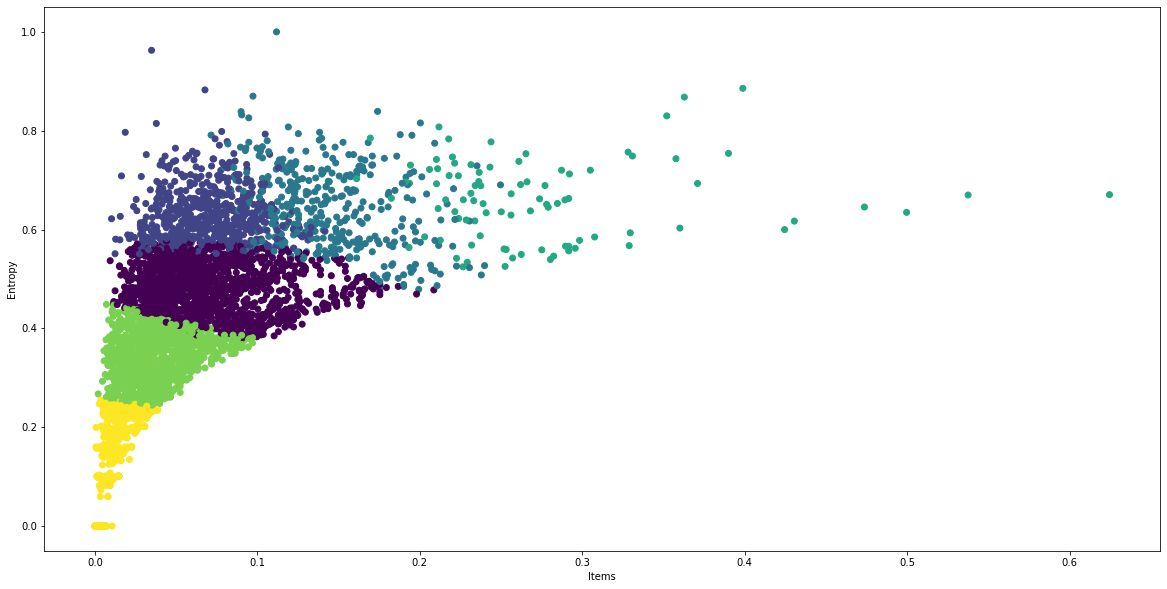

In [24]:
plt.figure(figsize=(20, 10))
plt.xlabel("Items")
plt.ylabel("Entropy")
plt.scatter(
    x = customer_indicators["I"],
    y = customer_indicators["E"],
    c = clusters
)

In [25]:
customer_indicators.to_csv("../../indicators.csv")